**Part 3.**

**Transfer Learning**

*Part 1.*

Summary of MobileNetV2 Structure:

Input: 3×224×224 (RGB image).

Preprocessing: Resize, convert to tensor, normalize.

Architecture: Convolutional layers with Inverted Residual Blocks and Depthwise Separable Convolutions.

Output: A logits vector with dimensions 1×N (default 1000 classes).

In [1]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
from PIL import Image
import json

Load the pre-trained MobileNetV2 model

In [2]:
# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 197MB/s]


*Part 2.*

Preprocess a sample image and find the output of the network.

get top 3 classes.

In [3]:
model.eval()

# Download the image from GitHub
image_url = "https://raw.githubusercontent.com/Ehsanacc/Deep-Learning-Course/main/Assignment%203/Part%203/sample.jpg"
image_path = "/kaggle/working/sample.jpg"
response = requests.get(image_url)
if response.status_code == 200:
    with open(image_path, "wb") as f:
        f.write(response.content)
    print(f"Image downloaded successfully and saved to {image_path}")
else:
    print(f"Failed to download image. Status code: {response.status_code}")


# Preprocessing transformations for the input image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize(          # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(input_tensor)

# Get top 3 predictions
probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Apply softmax
top3_prob, top3_classes = torch.topk(probabilities, 3)  # Get top 3 probabilities and indices

# Load ImageNet class labels
imagenet_classes_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = requests.get(imagenet_classes_url)

if response.status_code == 200:
    imagenet_classes = json.loads(response.text)
    print("Successfully loaded ImageNet class labels.")
else:
    print(f"Failed to load ImageNet class labels. Status code: {response.status_code}")
    imagenet_classes = []

# Map indices to class names
top3_class_names = [imagenet_classes[idx] for idx in top3_classes]

# Print the results
for i in range(3):
    print(f"Class: {top3_class_names[i]}, Probability: {top3_prob[i].item():.4f}")


Image downloaded successfully and saved to /kaggle/working/sample.jpg
Successfully loaded ImageNet class labels.
Class: Pekingese, Probability: 0.6485
Class: Shih Tzu, Probability: 0.2601
Class: Lhasa Apso, Probability: 0.0409


*Part 3.*

Use Oxford 102 Flower dataset.

Use MobileNetV2 for feature extraction and add classification layers.

Train the network using CrossEntropy.

In [4]:
# Dataset and DataLoader setup (as given)
data_dir = './oxford102'
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(          # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.Flowers102(root=data_dir, split="train", download=True, transform=transform)
val_dataset = datasets.Flowers102(root=data_dir, split="val", download=True, transform=transform)
test_dataset = datasets.Flowers102(root=data_dir, split="test", download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model setup (as given)
for param in model.features.parameters():
    param.requires_grad = False

num_classes = 102
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop with accuracy and cost tracking
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

100%|██████████| 344862509/344862509 [00:25<00:00, 13637692.18it/s]


Extracting oxford102/flowers-102/102flowers.tgz to oxford102/flowers-102


100%|██████████| 502/502 [00:00<00:00, 262241.95it/s]


100%|██████████| 14989/14989 [00:00<00:00, 7000937.93it/s]


Epoch 1/10, Train Loss: 4.4612, Train Accuracy: 0.0971, Val Loss: 3.3013, Val Accuracy: 0.4010
Epoch 2/10, Train Loss: 2.4578, Train Accuracy: 0.6588, Val Loss: 2.1217, Val Accuracy: 0.7216
Epoch 3/10, Train Loss: 1.4009, Train Accuracy: 0.8784, Val Loss: 1.5502, Val Accuracy: 0.8010
Epoch 4/10, Train Loss: 0.8853, Train Accuracy: 0.9333, Val Loss: 1.2706, Val Accuracy: 0.8049
Epoch 5/10, Train Loss: 0.6198, Train Accuracy: 0.9667, Val Loss: 1.0839, Val Accuracy: 0.8255
Epoch 6/10, Train Loss: 0.4430, Train Accuracy: 0.9804, Val Loss: 1.0418, Val Accuracy: 0.8353
Epoch 7/10, Train Loss: 0.4091, Train Accuracy: 0.9892, Val Loss: 1.0378, Val Accuracy: 0.8441
Epoch 8/10, Train Loss: 0.4031, Train Accuracy: 0.9912, Val Loss: 1.0053, Val Accuracy: 0.8539
Epoch 9/10, Train Loss: 0.3880, Train Accuracy: 0.9931, Val Loss: 1.0051, Val Accuracy: 0.8480
Epoch 10/10, Train Loss: 0.3637, Train Accuracy: 0.9980, Val Loss: 0.9870, Val Accuracy: 0.8500


Plot and Reports

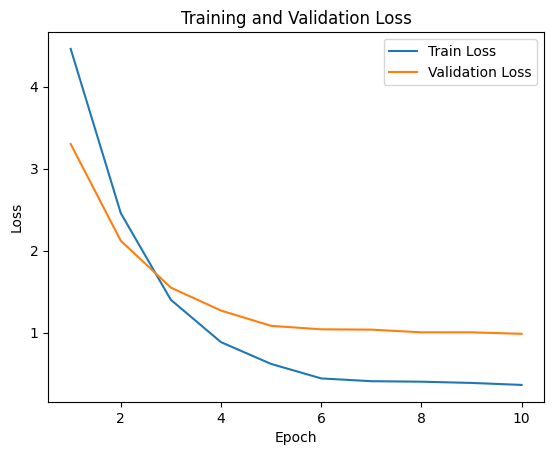

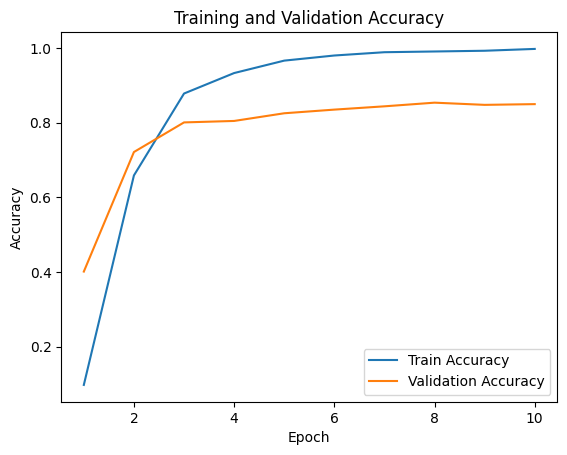

Test Loss: 1.0572, Test Accuracy: 0.8377


In [5]:
# Plotting Training and Validation Metrics
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test Accuracy and Cost
model.eval()
correct, total, running_test_loss = 0, 0, 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = correct / total
test_loss = running_test_loss / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


*Part 4.*

Testing pre-trained models VGG16 and ResNet50.

In this part we see ResNet50 has a better performance based on validation accuracy and test accuracy.

for test accuracy:         ResNet50 got 82.68%    &    VGG16 got 68.06%

ResNet50 has significantly less parameters compared to VGG16.

This means ResNet50 is a better platform to be used for transfer learning in this application.


Training resnet50...

Epoch 1/10, Train Loss: 4.5670, Train Accuracy: 0.0941, Val Loss: 3.4870, Val Accuracy: 0.2922
Epoch 2/10, Train Loss: 2.6058, Train Accuracy: 0.5657, Val Loss: 2.3217, Val Accuracy: 0.5627
Epoch 3/10, Train Loss: 1.4947, Train Accuracy: 0.8304, Val Loss: 1.6770, Val Accuracy: 0.7353
Epoch 4/10, Train Loss: 0.9885, Train Accuracy: 0.9059, Val Loss: 1.3625, Val Accuracy: 0.7676
Epoch 5/10, Train Loss: 0.6418, Train Accuracy: 0.9608, Val Loss: 1.1531, Val Accuracy: 0.8108
Epoch 6/10, Train Loss: 0.4653, Train Accuracy: 0.9853, Val Loss: 1.0751, Val Accuracy: 0.8461
Epoch 7/10, Train Loss: 0.4160, Train Accuracy: 0.9961, Val Loss: 1.0494, Val Accuracy: 0.8539
Epoch 8/10, Train Loss: 0.3980, Train Accuracy: 0.9971, Val Loss: 1.0305, Val Accuracy: 0.8520
Epoch 9/10, Train Loss: 0.3925, Train Accuracy: 0.9961, Val Loss: 1.0307, Val Accuracy: 0.8510
Epoch 10/10, Train Loss: 0.3822, Train Accuracy: 0.9941, Val Loss: 1.0099, Val Accuracy: 0.8549
resnet50 Test Accuracy: 0.

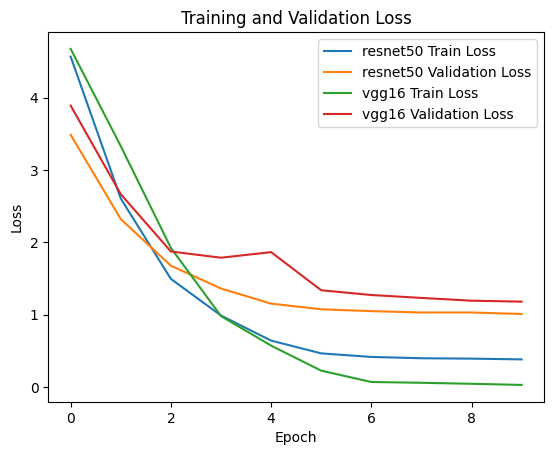

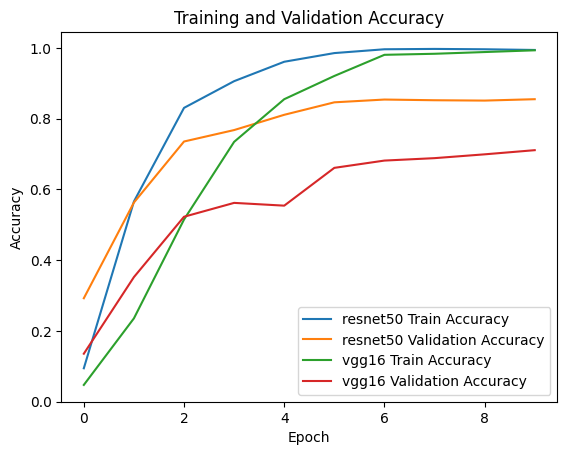

In [16]:
# Function to initialize the model
def initialize_model(model_name, num_classes, freeze_features=True):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        if freeze_features:
            for param in model.parameters():
                param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        if freeze_features:
            for param in model.features.parameters():
                param.requires_grad = False
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    else:
        raise ValueError("Invalid model name. Choose from 'resnet50', 'vgg16'")

    return model

# Training function
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=10):
    model = model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, "
              f"Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Evaluate function
def evaluate_model(model, test_loader, device):
    model = model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total

# Parameters
num_classes = 102
num_epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training and evaluation for each model
results = {}
for model_name in ["resnet50", "vgg16"]:
    print(f"\nTraining {model_name}...\n")
    model = initialize_model(model_name, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs
    )

    test_accuracy = evaluate_model(model, test_loader, device)
    total_params = sum(p.numel() for p in model.parameters())

    results[model_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "test_accuracy": test_accuracy,
        "total_params": total_params
    }
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}, Total Params: {total_params}")

# Compare results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"Total Parameters: {metrics['total_params']}")

# Plot losses
for model_name, metrics in results.items():
    plt.plot(metrics["train_losses"], label=f"{model_name} Train Loss")
    plt.plot(metrics["val_losses"], label=f"{model_name} Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot accuracies
for model_name, metrics in results.items():
    plt.plot(metrics["train_accuracies"], label=f"{model_name} Train Accuracy")
    plt.plot(metrics["val_accuracies"], label=f"{model_name} Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


*Part 5.*

In this part we are asked to train the network from scratch and only use the architecture.

we see the model managed to reach the accuracy 18.75% which is not appropriate at all.

in Part 3. we had the test accuracy 83.77% using pre trained weights.

We can see the the amount of change caused by the pre trained weights in this comparison.

In [13]:
# Initialize MobileNetV2 with random weights
def initialize_random_model(num_classes=102):
    print("Training MobileNetV2 from scratch (random initialization).")
    model = models.mobilenet_v2(pretrained=False)  # Random weights
    for param in model.parameters():
        param.requires_grad = True  # All layers are trainable
    
    # Replace the classifier for 102 classes
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model

# Parameters
num_classes = 102
num_epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = initialize_random_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Train the model
print("\nStarting Training...\n")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs
)

Training MobileNetV2 from scratch (random initialization).

Starting Training...

Epoch 1/10, Train Loss: 4.8624, Train Accuracy: 0.0118, Val Loss: 4.8922, Val Accuracy: 0.0098
Epoch 2/10, Train Loss: 4.3074, Train Accuracy: 0.0412, Val Loss: 5.8458, Val Accuracy: 0.0098
Epoch 3/10, Train Loss: 3.8519, Train Accuracy: 0.0725, Val Loss: 4.4068, Val Accuracy: 0.0520
Epoch 4/10, Train Loss: 3.6414, Train Accuracy: 0.1010, Val Loss: 4.5761, Val Accuracy: 0.0784
Epoch 5/10, Train Loss: 3.3721, Train Accuracy: 0.1265, Val Loss: 4.2170, Val Accuracy: 0.0922
Epoch 6/10, Train Loss: 2.9075, Train Accuracy: 0.2412, Val Loss: 3.3326, Val Accuracy: 0.1716
Epoch 7/10, Train Loss: 2.6959, Train Accuracy: 0.2804, Val Loss: 3.2816, Val Accuracy: 0.1843
Epoch 8/10, Train Loss: 2.6008, Train Accuracy: 0.3069, Val Loss: 3.2386, Val Accuracy: 0.2010
Epoch 9/10, Train Loss: 2.5041, Train Accuracy: 0.3255, Val Loss: 3.2129, Val Accuracy: 0.2069
Epoch 10/10, Train Loss: 2.4167, Train Accuracy: 0.3706, Val Lo

In [14]:
# Evaluate on test data
print("\nEvaluating on Test Data...\n")
test_accuracy = evaluate_model(model, test_loader, device)
print(f"Final Test Accuracy (Random Init MobileNetV2): {test_accuracy:.4f}")


Evaluating on Test Data...

Final Test Accuracy (Random Init MobileNetV2): 0.1875


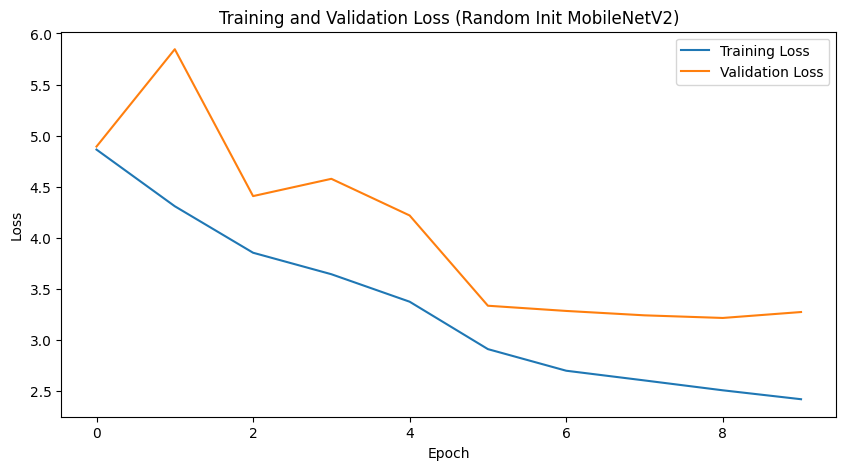

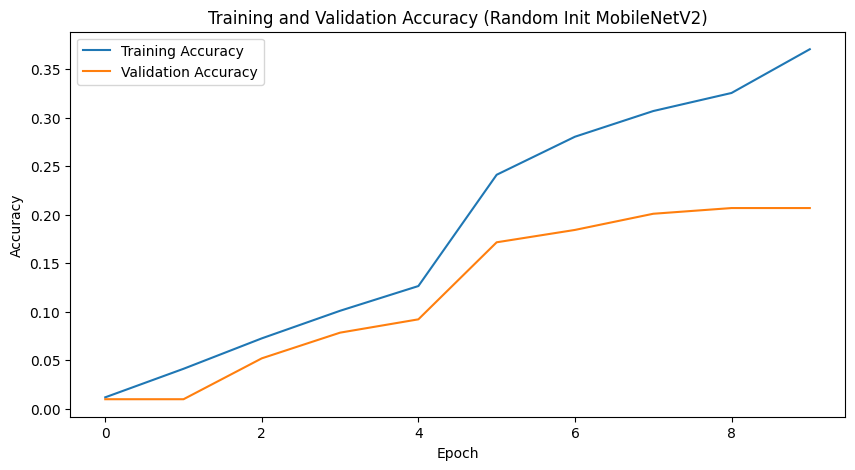

In [15]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (Random Init MobileNetV2)")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy (Random Init MobileNetV2)")
plt.legend()
plt.show()